## Libraries

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

## Define Constants

In [4]:
# 数据加载
batch_size = 32
img_size = (224, 224)

dataset_path = "../dataset/Garbage classification/Garbage classification"

## 数据预处理

In [3]:
# 直接从文件夹中加载数据，并自动划分训练/验证集
train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2, # 20% 作为验证集
    subset="training",
    seed=123, # 设定随机种子，保证每次划分一致
    image_size=img_size,
    batch_size=batch_size
)

val_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# 打印类别索引映射
class_names = train_dataset.class_names
print(f"类别索引映射: {class_names}")

# 数据增强
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
类别索引映射: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## 训练

In [4]:
# 加载预训练模型
base_model = keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                             include_top=False,
                                             weights="imagenet")
base_model.trainable = False  # 冻结特征提取层


# 构建分类模型
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # 增加Dropout防止过拟合
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# 编译模型
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# 训练模型
epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 643ms/step - accuracy: 0.4029 - loss: 1.8264 - val_accuracy: 0.7564 - val_loss: 0.9174
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 617ms/step - accuracy: 0.6815 - loss: 1.0750 - val_accuracy: 0.8119 - val_loss: 0.7894
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 620ms/step - accuracy: 0.7387 - loss: 0.9898 - val_accuracy: 0.8218 - val_loss: 0.7575
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 624ms/step - accuracy: 0.7663 - loss: 0.8613 - val_accuracy: 0.8515 - val_loss: 0.7017
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 628ms/step - accuracy: 0.7715 - loss: 0.8103 - val_accuracy: 0.8416 - val_loss: 0.6915
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 627ms/step - accuracy: 0.7882 - loss: 0.7982 - val_accuracy: 0.8495 - val_loss: 0.6793
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 621ms/step - accuracy: 0.8030 - loss: 0.7722 - val_accuracy: 0.8634 - val_loss: 0.6397
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 628ms/step - accuracy: 0.8082 - loss: 0.7501 - val_accu

In [5]:
# 解冻部分卷积层，进行微调
base_model.trainable = True
for layer in base_model.layers[:100]:  # 仅解冻后半部分层
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

fine_tune_epochs = 5
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=fine_tune_epochs)

Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 886ms/step - accuracy: 0.7505 - loss: 0.8807 - val_accuracy: 0.8218 - val_loss: 0.6918
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 868ms/step - accuracy: 0.8311 - loss: 0.6942 - val_accuracy: 0.7683 - val_loss: 0.8173
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 864ms/step - accuracy: 0.8735 - loss: 0.5638 - val_accuracy: 0.8198 - val_loss: 0.7035
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 867ms/step - accuracy: 0.8802 - loss: 0.5059 - val_accuracy: 0.8554 - val_loss: 0.6518
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 864ms/step - accuracy: 0.8995 - loss: 0.4845 - val_accuracy: 0.8475 - val_loss: 0.6519


## 绘制训练结果

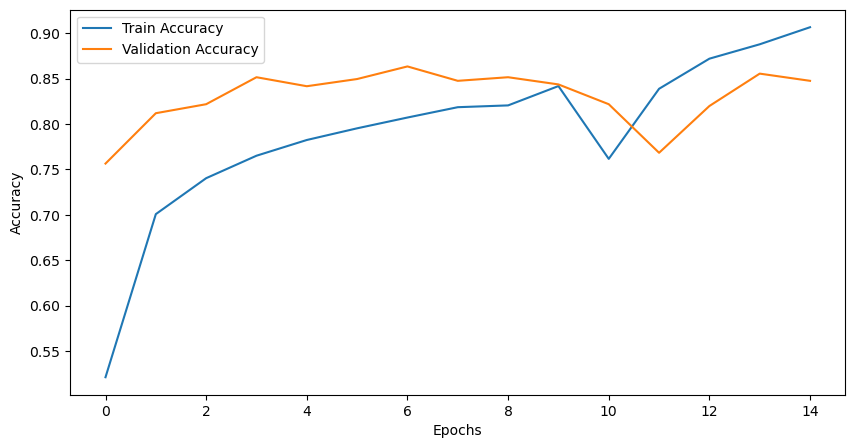

In [6]:
# accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

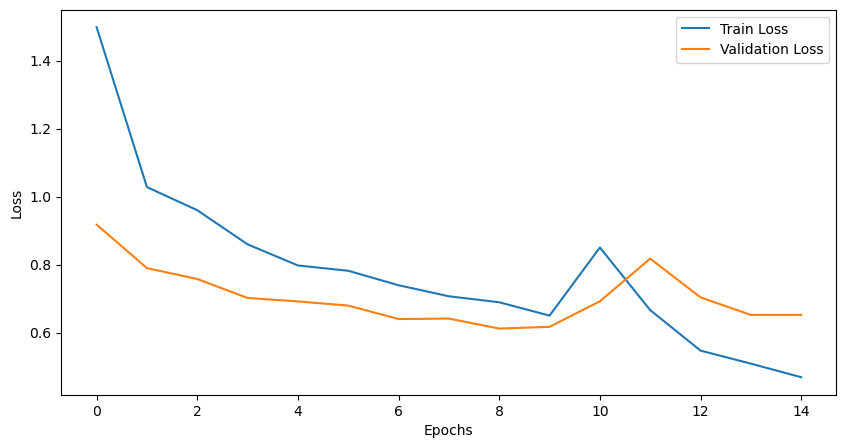

In [7]:
# loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 保存模型

In [8]:
model.save("classification_model.keras")
print("Saved!")

Saved!
